# 1.Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-learn
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    StandardScaler
)
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

#Feature-engine
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SelectBySingleFeaturePerformance

# 2.Display Settings

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
sklearn.set_config(transform_output='pandas')

# 3.Read Data

In [5]:
df=pd.read_csv(r'C:\SUFIYAN\STUDY MATERIALS\FOR CLASS\FOR CLASS\sagemaker-flights-price-prediction\data\train.csv')
df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,IndiGo,2019-06-12,Delhi,Cochin,10:35:00,01:30:00,895.0,1,No Info,5883
1,IndiGo,2019-06-18,Bengaluru,Delhi,10:10:00,13:00:00,170.0,0,No Info,3943
2,Jet Airways,2019-05-15,Kolkata,Bengaluru,09:35:00,10:55:00,1520.0,1,No Info,14151
3,Jet Airways,2019-06-03,Delhi,Cochin,19:45:00,19:00:00,1395.0,1,In-flight meal not included,10262
4,IndiGo,2019-05-18,Kolkata,Bengaluru,15:30:00,18:05:00,155.0,0,No Info,4804
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-06-27,Delhi,Cochin,20:55:00,12:35:00,940.0,1,In-flight meal not included,10262
636,Jet Airways,2019-06-03,Delhi,Cochin,17:30:00,19:00:00,1530.0,1,No Info,14714
637,Jet Airways,2019-03-21,Delhi,Cochin,17:30:00,18:50:00,1520.0,1,In-flight meal not included,5963
638,Multiple carriers,2019-05-09,Delhi,Cochin,09:00:00,21:00:00,720.0,1,No Info,13727


In [6]:
x_train=df.drop(columns='price')
y_train=df.price.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    float64
 7   total_stops      640 non-null    int64  
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


# 4.Transformation Operations

In [8]:
x_train.airline.value_counts()/100

airline
Jet Airways           2.36
IndiGo                1.33
Air India             0.96
Multiple carriers     0.67
SpiceJet              0.48
Air Asia              0.26
Vistara               0.23
GoAir                 0.06
Multiple carriers     0.02
Trujet                0.01
Jet Airways           0.01
Vistara               0.01
Name: count, dtype: float64

##  4.1 Airline

In [9]:
airline_transform=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('rle',RareLabelEncoder(tol=0.1,replace_with='Others',n_categories=2)),
    ('ohe',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

airline_transform.fit_transform(x_train.loc[:,['airline']])

,airline_Air India,airline_IndiGo,airline_Jet Airways,airline_Multiple carriers,airline_Others
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,0.0,0.0,1.0,0.0


In [10]:
x_train.loc[:,['airline']]

,airline
0,IndiGo
1,IndiGo
2,Jet Airways
3,Jet Airways
4,IndiGo
...,...
635,Jet Airways
636,Jet Airways
637,Jet Airways
638,Multiple carriers


## 4.2 Date of Journey

In [250]:
df.date_of_journey

0      2019-06-12
1      2019-06-18
2      2019-05-15
3      2019-06-03
4      2019-05-18
          ...    
635    2019-06-27
636    2019-06-03
637    2019-03-21
638    2019-05-09
639    2019-06-15
Name: date_of_journey, Length: 640, dtype: object

In [251]:
fte=['month','week','day_of_week','day_of_year']
doj_transform=Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=fte, yearfirst=True, format="mixed")),
    ('scaler',MinMaxScaler())
])
doj_transform.fit_transform(x_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.882353,0.333333,0.872881
1,1.000000,0.941176,0.166667,0.923729
2,0.666667,0.647059,0.333333,0.635593
3,1.000000,0.823529,0.000000,0.796610
4,0.666667,0.647059,0.833333,0.661017
...,...,...,...,...
635,1.000000,1.000000,0.500000,1.000000
636,1.000000,0.823529,0.000000,0.796610
637,0.000000,0.176471,0.500000,0.169492
638,0.666667,0.588235,0.500000,0.584746


# 4.3 Source & Destination

In [252]:
x_train.source.value_counts()

source
Delhi        269
Kolkata      169
Bengaluru    137
Mumbai        42
Chennai       23
Name: count, dtype: int64

In [253]:
x_train.destination.value_counts()

destination
Cochin       269
Bengaluru    169
Delhi         72
New Delhi     65
Hyderabad     42
Kolkata       23
Name: count, dtype: int64

In [254]:
location_subset=x_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Delhi,Cochin
1,Bengaluru,Delhi
2,Kolkata,Bengaluru
3,Delhi,Cochin
4,Kolkata,Bengaluru
...,...,...
635,Delhi,Cochin
636,Delhi,Cochin
637,Delhi,Cochin
638,Delhi,Cochin


In [255]:
location_1=Pipeline(steps=[
    ('grouper',RareLabelEncoder(replace_with='Others',n_categories=2,tol=0.1)),
    ('encoder',MeanEncoder()),
    ('scaler',PowerTransformer()),
])


In [256]:
def is_north(x):
    north_city=['Delhi','Kolkata','New Delhi','Mumbai']
    columns=x.columns.to_list()
    return(
        x
        .assign(**{
            f"{col}_is_north": x.loc[:,col].isin(north_city).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


In [257]:
location_transformer=FeatureUnion(transformer_list=[
    ('part1',location_1),
    ('part2',FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.084781,0.605888,1,0
1,-0.582297,-1.625443,0,1
2,-0.532611,-0.361434,1,0
3,1.084781,0.605888,1,0
4,-0.532611,-0.361434,1,0
...,...,...,...,...
635,1.084781,0.605888,1,0
636,1.084781,0.605888,1,0
637,1.084781,0.605888,1,0
638,1.084781,0.605888,1,0


## 4.4 Departure & Arrival Time

In [258]:
time_subset=df.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,10:35:00,01:30:00
1,10:10:00,13:00:00
2,09:35:00,10:55:00
3,19:45:00,19:00:00
4,15:30:00,18:05:00
...,...,...
635,20:55:00,12:35:00
636,17:30:00,19:00:00
637,17:30:00,18:50:00
638,09:00:00,21:00:00


In [259]:
time_1=Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scale',MinMaxScaler())
])

In [260]:
time_1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.409091,0.636364,0.043478,0.545455
1,0.409091,0.181818,0.565217,0.000000
2,0.363636,0.636364,0.434783,1.000000
3,0.818182,0.818182,0.826087,0.000000
4,0.636364,0.545455,0.782609,0.090909
...,...,...,...,...
635,0.863636,1.000000,0.521739,0.636364
636,0.727273,0.545455,0.826087,0.000000
637,0.727273,0.545455,0.782609,0.909091
638,0.363636,0.000000,0.913043,0.000000


In [261]:
def part_of_day(x,morning=4,noon=12,eve=16,night=20):
    columns=x.columns.to_list()
    x_temp=x.assign(**{
        col: pd.to_datetime(x.loc[:,col]).dt.hour
        for col in columns
    })
    return (x_temp
           .assign(**{
               f'{col}_part_of_day': np.select([
                   x_temp.loc[:,col].between(morning,noon,inclusive='left'),
                   x_temp.loc[:,col].between(noon,eve,inclusive='left'),
                   x_temp.loc[:,col].between(eve,night,inclusive='left')],
                    ['morning','afternoon','evening'],
                    default='night')
               for col in columns
           }).drop(columns=columns))
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,night
1,morning,afternoon
2,morning,morning
3,evening,evening
4,afternoon,evening
...,...,...
635,night,afternoon
636,evening,evening
637,evening,evening
638,morning,night


In [262]:
time_2=Pipeline(steps=[
    ('day_part',FunctionTransformer(func=part_of_day)),
    ('count',CountFrequencyEncoder()),
    ('scale',MinMaxScaler()),



])
time_2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,1.000000
1,1.000000,0.000000
2,1.000000,0.885965
3,0.198238,0.780702
4,0.000000,0.780702
...,...,...
635,0.088106,0.000000
636,0.198238,0.780702
637,0.198238,0.780702
638,1.000000,1.000000


In [263]:
time_transformer=FeatureUnion(transformer_list=[
    ('time1',time_1),
    ('time2',time_2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.409091,0.636364,0.043478,0.545455,1.000000,1.000000
1,0.409091,0.181818,0.565217,0.000000,1.000000,0.000000
2,0.363636,0.636364,0.434783,1.000000,1.000000,0.885965
3,0.818182,0.818182,0.826087,0.000000,0.198238,0.780702
4,0.636364,0.545455,0.782609,0.090909,0.000000,0.780702
...,...,...,...,...,...,...
635,0.863636,1.000000,0.521739,0.636364,0.088106,0.000000
636,0.727273,0.545455,0.826087,0.000000,0.198238,0.780702
637,0.727273,0.545455,0.782609,0.909091,0.198238,0.780702
638,0.363636,0.000000,0.913043,0.000000,1.000000,1.000000


## 4.5 Duration

In [264]:
df.duration.unique()

array([ 895.,  170., 1520., 1395.,  155.,   90., 1425., 1610.,  175.,
        380.,  195.,  570.,  805.,  325., 1025.,  830.,  560., 1505.,
       1325.,  630.,  145.,  750.,  590.,  510., 1530.,  135.,  675.,
        975.,  165., 1420.,  880.,  315.,  140.,  180.,  585.,  835.,
        785.,  150.,  440.,  435., 1480., 1180., 1200., 1125.,  290.,
        640.,  810., 1580., 1495.,  480.,  705., 1485.,  925., 1275.,
        840.,  500.,  710.,  540., 1335.,  535., 1270.,  220.,  685.,
       1170.,  600., 1615.,   80.,  720., 1355.,  330., 2105.,  415.,
        300.,  450.,  660., 1320.,  350., 1430., 1570.,  295., 1315.,
        160.,  765.,  760.,  865.,   85.,  940.,  420., 1655.,  550.,
        610.,  360., 1350., 1940., 1640., 1210.,  485.,  520.,  965.,
       1700., 1760.,  455.,  730.,  665.,  690.,  385., 1475.,  970.,
        800.,  260.,  695.,  565.,  340., 1710.,  335.,  910.,  860.,
       1140.,  190.,  370., 1400., 1100.,  505.,  345., 1295., 1600.,
        820., 1535.,

In [265]:
(x_train
	.duration
	.quantile([0.25, 0.5, 0.75])

)

0.25    170.00
0.50    560.00
0.75    891.25
Name: duration, dtype: float64

In [266]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [267]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(x_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.000000e+00,1.000000,1.000000
1,0.0,0.000000e+00,0.904837,0.904837
2,0.0,0.000000e+00,1.000000,1.000000
3,0.0,0.000000e+00,1.000000,1.000000
4,0.0,0.000000e+00,0.904837,0.904837
...,...,...,...,...
635,0.0,0.000000e+00,1.000000,1.000000
636,0.0,0.000000e+00,1.000000,1.000000
637,0.0,0.000000e+00,1.000000,1.000000
638,0.0,0.000000e+00,1.000000,1.000000


In [295]:
def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short),
                                    X.duration.between(short, med, inclusive="left")],
                                    ["short", "medium"],
                                    default="long"))
        .drop(columns="duration")
    )

def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

In [300]:
duration_1=Pipeline(steps=[
    ('rbf',RBFPercentileSimilarity()),
    ('scaler',PowerTransformer())
])

duration_2=Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder",OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union=FeatureUnion(transformer_list=[
    ('dur_1',duration_1),
    ('dur_2',duration_2),
    ('dur_over',FunctionTransformer(func=is_over)),
    ('scaler',StandardScaler())
])

duration_transformer=Pipeline(steps=[
    ('outliers',Winsorizer()),
    ('impute',SimpleImputer(strategy='median')),
    ('union',duration_union)
])

In [301]:
duration_transformer.fit_transform(x_train.loc[:,['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.373913,-0.098701,11.269546,2.0,0,0.525256
1,3.056399,-0.098701,-0.088764,0.0,0,-0.955486
2,-0.373913,-0.098701,-0.088764,2.0,1,1.801758
3,-0.373913,-0.098701,-0.088764,2.0,1,1.546458
4,-0.373913,-0.098701,-0.088764,0.0,0,-0.986122
...,...,...,...,...,...,...
635,-0.373913,-0.098701,-0.088764,2.0,0,0.617165
636,-0.373913,-0.098701,-0.088764,2.0,1,1.822182
637,-0.373913,-0.098701,-0.088764,2.0,1,1.801758
638,-0.373913,-0.098701,-0.088764,2.0,0,0.167836


## 4.6 Total Stops

In [302]:
x_train.total_stops.value_counts().sort_values(ascending=True)

total_stops
3      3
2     93
0    207
1    337
Name: count, dtype: int64

In [303]:
def is_direct(x):
    return x.assign(is_direct_flight=x_train.total_stops.eq(0).astype(int))

stops_transformer=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('is_direct',FunctionTransformer(func=is_direct))
])

In [304]:
stops_transformer.fit_transform(x_train.loc[:,['total_stops']])

,total_stops,is_direct_flight
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


## 4.7 Additional info

In [305]:
df.loc[:,['additional_info']]

,additional_info
0,No Info
1,No Info
2,No Info
3,In-flight meal not included
4,No Info
...,...
635,In-flight meal not included
636,No Info
637,In-flight meal not included
638,No Info


In [306]:
x_train.additional_info.value_counts()/100

additional_info
No Info                         4.97
In-flight meal not included     1.25
No check-in baggage included    0.12
1 Long layover                  0.03
Change airports                 0.02
Business class                  0.01
Name: count, dtype: float64

In [307]:
info_1=Pipeline(steps=[
    ('group',RareLabelEncoder(tol=0.1,n_categories=2,replace_with='others')),
    ('encode',OneHotEncoder(handle_unknown='ignore',sparse_output=False)),
    
])
info_1.fit_transform(x_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_others
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,1.0,0.0,0.0
638,0.0,1.0,0.0


In [308]:
def have_info(x):
    return x.assign(additional_info=x.additional_info.ne('No Info').astype(int))
    
have_info(x_train.loc[:,['additional_info']])

,additional_info
0,0
1,0
2,0
3,1
4,0
...,...
635,1
636,0
637,1
638,0


In [309]:
FunctionTransformer(func=have_info)

FunctionTransformer(func=<function have_info at 0x000001FA06E37910>)

In [310]:
info_union=FeatureUnion(transformer_list=[
    ('info_1',info_1),
    ('have_info',FunctionTransformer(func=have_info))
])
info_union.fit_transform(x_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_others,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,1.0,0.0,0.0,1
638,0.0,1.0,0.0,0


In [311]:
info_transformer=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='constant',fill_value='unknown')),
    ('union',info_union)
])

In [312]:
info_transformer.fit_transform(x_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_others,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,1.0,0.0,0.0,1
638,0.0,1.0,0.0,0


# 5. Column Transformer

In [313]:
columntransformed=ColumnTransformer(transformers=[
    ('air',airline_transform,['airline']),
    ('doj',doj_transform,['date_of_journey']),
    ('s&d',location_transformer,['source','destination']),
    ('time',time_transformer,['dep_time','arrival_time']),
    ('dur',duration_transformer,['duration']),
    ('stops',stops_transformer,['total_stops']),
    ('info',info_transformer,['additional_info'])
],remainder='passthrough')

In [314]:
columntransformed.fit_transform(x_train,y_train)

,air__airline_Air India,air__airline_IndiGo,air__airline_Jet Airways,air__airline_Multiple carriers,air__airline_Others,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,s&d__source,s&d__destination,s&d__source_is_north,s&d__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_others,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,1.084781,0.605888,1,0,0.409091,0.636364,0.043478,0.545455,1.000000,1.000000,-0.373913,-0.098701,11.269546,2.0,0,0.525256,1,0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,1.000000,0.941176,0.166667,0.923729,-0.582297,-1.625443,0,1,0.409091,0.181818,0.565217,0.000000,1.000000,0.000000,3.056399,-0.098701,-0.088764,0.0,0,-0.955486,0,1,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-0.532611,-0.361434,1,0,0.363636,0.636364,0.434783,1.000000,1.000000,0.885965,-0.373913,-0.098701,-0.088764,2.0,1,1.801758,1,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,1.084781,0.605888,1,0,0.818182,0.818182,0.826087,0.000000,0.198238,0.780702,-0.373913,-0.098701,-0.088764,2.0,1,1.546458,1,0,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.532611,-0.361434,1,0,0.636364,0.545455,0.782609,0.090909,0.000000,0.780702,-0.373913,-0.098701,-0.088764,0.0,0,-0.986122,0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,1.084781,0.605888,1,0,0.863636,1.000000,0.521739,0.636364,0.088106,0.000000,-0.373913,-0.098701,-0.088764,2.0,0,0.617165,1,0,1.0,0.0,0.0,1
636,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,1.084781,0.605888,1,0,0.727273,0.545455,0.826087,0.000000,0.198238,0.780702,-0.373913,-0.098701,-0.088764,2.0,1,1.822182,1,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.084781,0.605888,1,0,0.727273,0.545455,0.782609,0.909091,0.198238,0.780702,-0.373913,-0.098701,-0.088764,2.0,1,1.801758,1,0,1.0,0.0,0.0,1
638,0.0,0.0,0.0,1.0,0.0,0.666667,0.588235,0.500000,0.584746,1.084781,0.605888,1,0,0.363636,0.000000,0.913043,0.000000,1.000000,1.000000,-0.373913,-0.098701,-0.088764,2.0,0,0.167836,1,0,0.0,1.0,0.0,0


In [315]:
columntransformed.transformers

[('air',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                  ('rle',
                   RareLabelEncoder(n_categories=2, replace_with='Others',
                                    tol=0.1)),
                  ('ohe',
                   OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
  ['airline']),
 ('doj',
  Pipeline(steps=[('dt',
                   DatetimeFeatures(features_to_extract=['month', 'week',
                                                         'day_of_week',
                                                         'day_of_year'],
                                    format='mixed', yearfirst=True)),
                  ('scaler', MinMaxScaler())]),
  ['date_of_journey']),
 ('s&d',
  FeatureUnion(transformer_list=[('part1',
                                  Pipeline(steps=[('grouper',
                                                   RareLabelEncoder(n_categories=2,
                                                     

# 5. Feature Selection

In [316]:
est=RandomForestRegressor(n_estimators=10,max_depth=3,random_state=42)

selection=SelectBySingleFeaturePerformance(estimator=est,scoring='r2',threshold=0.1)

# 6. Gathering all

In [329]:
preprocessor=Pipeline(steps=[
    ('column',columntransformed),
    ('select',selection)
])

preprocessor.fit_transform(x_train,y_train)

,air__airline_IndiGo,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,s&d__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.882353,0.872881,0.605888,-0.373913,2.0,0.525256,1,0
1,1.0,0.0,0.941176,0.923729,-1.625443,3.056399,0.0,-0.955486,0,1
2,0.0,1.0,0.647059,0.635593,-0.361434,-0.373913,2.0,1.801758,1,0
3,0.0,1.0,0.823529,0.796610,0.605888,-0.373913,2.0,1.546458,1,0
4,1.0,0.0,0.647059,0.661017,-0.361434,-0.373913,0.0,-0.986122,0,1
...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,1.000000,1.000000,0.605888,-0.373913,2.0,0.617165,1,0
636,0.0,1.0,0.823529,0.796610,0.605888,-0.373913,2.0,1.822182,1,0
637,0.0,1.0,0.176471,0.169492,0.605888,-0.373913,2.0,1.801758,1,0
638,0.0,0.0,0.588235,0.584746,0.605888,-0.373913,2.0,0.167836,1,0


In [327]:
preprocessor

Pipeline(steps=[('column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Others',
                                                                                    tol=0.1)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   DatetimeFea...
                                                                                                                                     replace_with='others',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encode',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('have_info',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001FA06E37910>))]))]),
                                                  ['additional_info'])])),
                ('select',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [318]:
selection.feature_performance_

{'air__airline_Air India': -0.00463757494658094,
 'air__airline_IndiGo': 0.14836860900528812,
 'air__airline_Jet Airways': 0.18832318984819005,
 'air__airline_Multiple carriers': 0.013456490126681486,
 'air__airline_Others': 0.07413208111205154,
 'doj__date_of_journey_month': 0.08041191413432547,
 'doj__date_of_journey_week': 0.19957622711535175,
 'doj__date_of_journey_day_of_week': -0.01136716966320058,
 'doj__date_of_journey_day_of_year': 0.23052226569348833,
 's&d__source': 0.08184473672714228,
 's&d__destination': 0.20397114453574616,
 's&d__source_is_north': 0.0023510942927036003,
 's&d__destination_is_north': 0.0023510942927036003,
 'time__dep_time_hour': 0.01181107833688507,
 'time__dep_time_minute': -0.003912966227734849,
 'time__arrival_time_hour': 0.05167671170065905,
 'time__arrival_time_minute': 0.02879783756996024,
 'time__dep_time_part_of_day': -0.008383707347407713,
 'time__arrival_time_part_of_day': 0.02082819493519339,
 'dur__duration_rbf_25': 0.11371493964877928,
 'du

In [319]:
selection.features_to_drop_

['air__airline_Air India',
 'air__airline_Multiple carriers',
 'air__airline_Others',
 'doj__date_of_journey_month',
 'doj__date_of_journey_day_of_week',
 's&d__source',
 's&d__source_is_north',
 's&d__destination_is_north',
 'time__dep_time_hour',
 'time__dep_time_minute',
 'time__arrival_time_hour',
 'time__arrival_time_minute',
 'time__dep_time_part_of_day',
 'time__arrival_time_part_of_day',
 'dur__duration_rbf_50',
 'dur__duration_rbf_75',
 'dur__duration_over_1000',
 'info__additional_info_In-flight meal not included',
 'info__additional_info_No Info',
 'info__additional_info_others',
 'info__additional_info']

# Visualization

In [320]:
feature_performances = preprocessor.named_steps["select"].feature_performance_
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_others': -0.018385572623413116,
 'doj__date_of_journey_day_of_week': -0.01136716966320058,
 'dur__duration_rbf_50': -0.010353549957700103,
 'time__dep_time_part_of_day': -0.008383707347407713,
 'dur__duration_rbf_75': -0.005700782903233541,
 'air__airline_Air India': -0.00463757494658094,
 'info__additional_info_In-flight meal not included': -0.00435132627393157,
 'time__dep_time_minute': -0.003912966227734849,
 'info__additional_info_No Info': -0.0012409982159332273,
 'info__additional_info': -0.0012409982159332273,
 's&d__source_is_north': 0.0023510942927036003,
 's&d__destination_is_north': 0.0023510942927036003,
 'time__dep_time_hour': 0.01181107833688507,
 'air__airline_Multiple carriers': 0.013456490126681486,
 'time__arrival_time_part_of_day': 0.02082819493519339,
 'time__arrival_time_minute': 0.02879783756996024,
 'time__arrival_time_hour': 0.05167671170065905,
 'air__airline_Others': 0.07413208111205154,
 'doj__date_of_journey_month': 0.0804119141343254

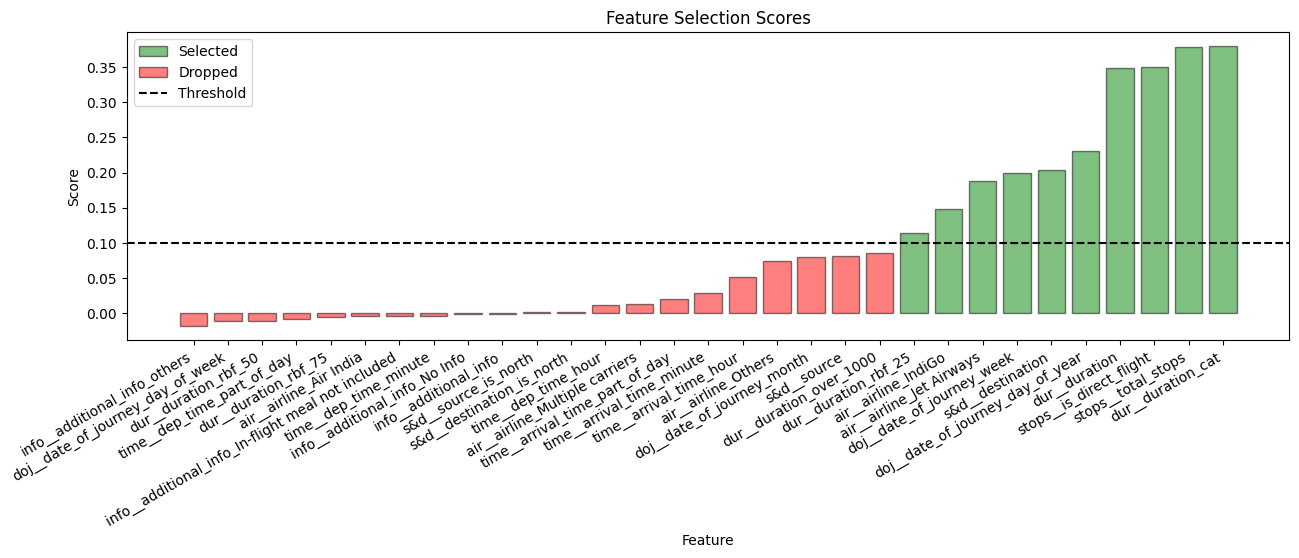

In [321]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- Selecting 10 Best Features in terms of Performance out of 31 columns